Hands-on lab on error mitigation with Mitiq.

In [49]:
from mitiq.benchmarks import generate_ghz_circuit
n_qubits = 7

circuit = generate_ghz_circuit(n_qubits=n_qubits, return_type="qiskit")
print("GHZ circuit:")
print(circuit)

GHZ circuit:
     ┌───┐                              
q_0: ┤ H ├──■───────────────────────────
     └───┘┌─┴─┐                         
q_1: ─────┤ X ├──■──────────────────────
          └───┘┌─┴─┐                    
q_2: ──────────┤ X ├──■─────────────────
               └───┘┌─┴─┐               
q_3: ───────────────┤ X ├──■────────────
                    └───┘┌─┴─┐          
q_4: ────────────────────┤ X ├──■───────
                         └───┘┌─┴─┐     
q_5: ─────────────────────────┤ X ├──■──
                              └───┘┌─┴─┐
q_6: ──────────────────────────────┤ X ├
                                   └───┘


In [50]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2 as FakeJakarta  # Fake (simulated) QPUs

# Number of measurements
shots = 10 ** 5

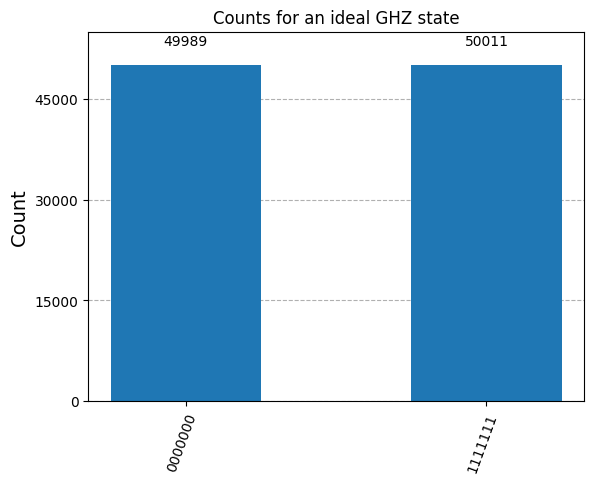

In [51]:
ideal_backend = AerSimulator()

# Append measurement gates
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

#######################################

# TODO: Run circuit_to_run on the ideal backend and get the ideal counts
ideal_result = ideal_backend.run(circuit_to_run, shots=shots).result()
ideal_counts = ideal_result.get_counts(circuit_to_run)

#######################################


plot_histogram(ideal_counts, title='Counts for an ideal GHZ state')

In [52]:
noisy_backend = FakeJakarta() # QPU emulator

# Compile the circuit into the native gates of the backend
compiled_circuit = transpile(circuit_to_run, noisy_backend)

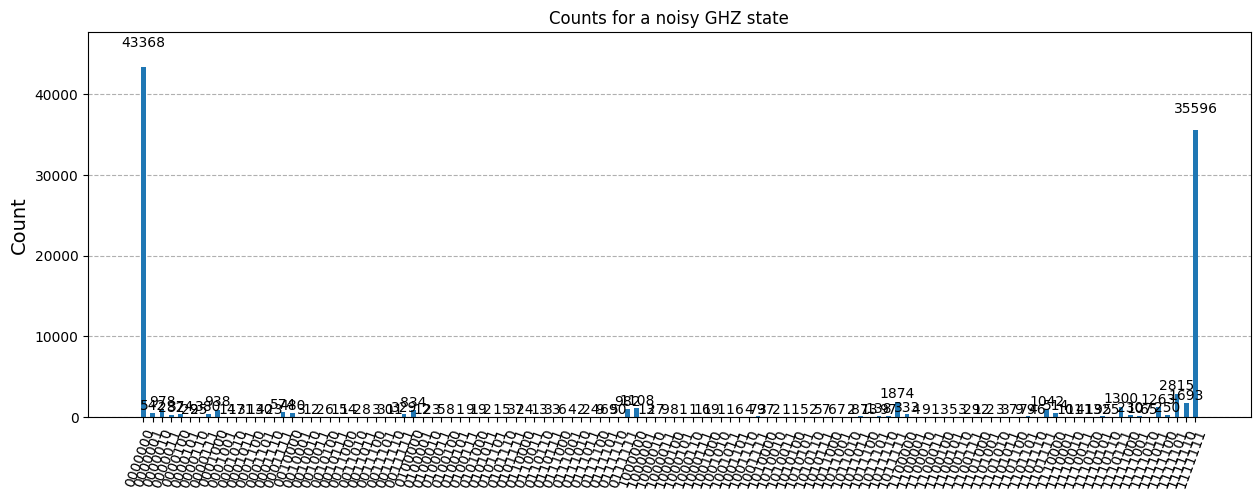

In [53]:
# Run the simulation on the noisy backend
#######################################

# TODO: Run circuit_to_run on the noisy backend and get the noisy counts
noisy_result = noisy_backend.run(compiled_circuit, shots=shots).result()
noisy_counts = noisy_result.get_counts(compiled_circuit)

#######################################
plot_histogram(noisy_counts, title='Counts for a noisy GHZ state', figsize=(15, 5))

In [54]:
ideal_expectation_value = (ideal_counts[n_qubits * "0"] + ideal_counts[n_qubits * "1"]) / shots
print(f"The ideal expectation value is <A> = {ideal_expectation_value}")

noisy_expectation_value = (noisy_counts[n_qubits * "0"] + noisy_counts[n_qubits * "1"]) / shots
print(f"The noisy expectation value is <A> = {noisy_expectation_value}")

The ideal expectation value is <A> = 1.0
The noisy expectation value is <A> = 0.78964


In [55]:
def execute(compiled_circuit):
    """Executes the input circuits and returns the expectation value of A=|00..0><00..0| + |11..1><11..1|."""
    print("Executing a circuit of depth:", compiled_circuit.depth())
    ######################################
    
    # TODO: cope and paste the instructions that we previously used to obtain noisy <A>.
    noisy_result = noisy_backend.run(compiled_circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(compiled_circuit)
    noisy_expectation_value = (noisy_counts[n_qubits * "0"] + noisy_counts[n_qubits * "1"]) / shots

    #######################################

    return noisy_expectation_value

In [56]:
print(f"The noisy expectation value is <A> = {execute(compiled_circuit)}")

Executing a circuit of depth: 20
The noisy expectation value is <A> = 0.7927


In [57]:
from mitiq import zne

zne_value = zne.execute_with_zne(
    circuit= compiled_circuit, # TODO... docs: https://mitiq.readthedocs.io/en/stable/apidoc.html#module-mitiq.zne.zne
    executor= execute # TODO...
)
                                
print(f"The error mitigated expectation value is <A> = {zne_value}")

Executing a circuit of depth: 20
Executing a circuit of depth: 40
Executing a circuit of depth: 58
The error mitigated expectation value is <A> = 0.8240899999999995


In [58]:
print(f"Error without Mitiq: {abs(ideal_expectation_value - noisy_expectation_value)}")
print(f"Error with Mitiq: {abs(ideal_expectation_value - zne_value)}")

Error without Mitiq: 0.21036
Error with Mitiq: 0.17591000000000045


Executing a circuit of depth: 20
Executing a circuit of depth: 38
Executing a circuit of depth: 58
The error mitigated expectation value is <A> = 0.8150199999999997


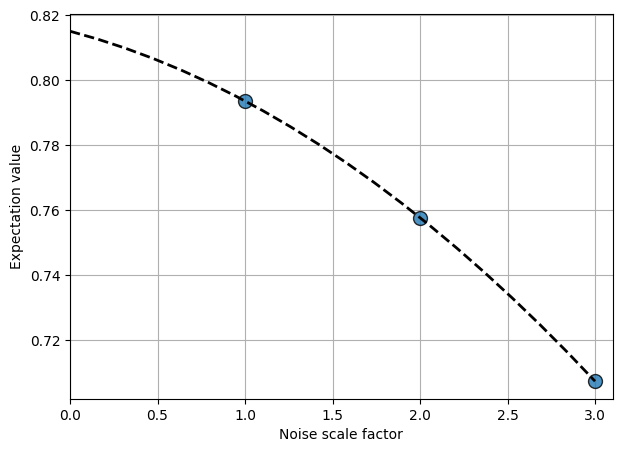

In [59]:
from mitiq import zne

# Select a noise scaling method
folding_function = zne.scaling.fold_global

# Select an inference method
factory = zne.inference.RichardsonFactory(scale_factors = [1.0, 2.0, 3.0])

zne_value = zne.execute_with_zne(
    compiled_circuit, 
    executor=execute,
    factory=factory,
    scale_noise= folding_function
    # TODO: pass the "folding_function" and the "factory" as arguments. 
    # See docs: https://mitiq.readthedocs.io/en/stable/apidoc.html#module-mitiq.zne.zne
)
factory.plot_fit()
print(f"The error mitigated expectation value is <A> = {zne_value}")

In [60]:
locally_folded_circuit = zne.scaling.folding.fold_gates_at_random(circuit,3)
# Link to docs: https://mitiq.readthedocs.io/en/stable/apidoc.html#mitiq.zne.scaling.folding.fold_gates_at_random

print("Locally folded GHZ circuit:")
print(locally_folded_circuit) # folded all of them????

Locally folded GHZ circuit:
     ┌───┐┌───┐┌───┐                                                       »
q_0: ┤ H ├┤ H ├┤ H ├──■────■────■──────────────────────────────────────────»
     └───┘└───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐                                        »
q_1: ───────────────┤ X ├┤ X ├┤ X ├──■────■────■───────────────────────────»
                    └───┘└───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐                         »
q_2: ──────────────────────────────┤ X ├┤ X ├┤ X ├──■────■────■────────────»
                                   └───┘└───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐          »
q_3: ─────────────────────────────────────────────┤ X ├┤ X ├┤ X ├──■────■──»
                                                  └───┘└───┘└───┘┌─┴─┐┌─┴─┐»
q_4: ────────────────────────────────────────────────────────────┤ X ├┤ X ├»
                                                                 └───┘└───┘»
q_5: ──────────────────────────────────────────────────────────────────────»
                                                

In [61]:
globally_folded_circuit = zne.scaling.folding.fold_global(circuit, 3)
# Link to docs: https://mitiq.readthedocs.io/en/stable/apidoc.html#mitiq.zne.scaling.folding.fold_global

print("Globally folded GHZ circuit:")
print(globally_folded_circuit)

Globally folded GHZ circuit:
     ┌───┐                                                            ┌───┐»
q_0: ┤ H ├──■──────────────────────────────────────────────────────■──┤ H ├»
     └───┘┌─┴─┐                                                  ┌─┴─┐└───┘»
q_1: ─────┤ X ├──■────────────────────────────────────────────■──┤ X ├─────»
          └───┘┌─┴─┐                                        ┌─┴─┐└───┘     »
q_2: ──────────┤ X ├──■──────────────────────────────────■──┤ X ├──────────»
               └───┘┌─┴─┐                              ┌─┴─┐└───┘          »
q_3: ───────────────┤ X ├──■────────────────────────■──┤ X ├───────────────»
                    └───┘┌─┴─┐                    ┌─┴─┐└───┘               »
q_4: ────────────────────┤ X ├──■──────────────■──┤ X ├────────────────────»
                         └───┘┌─┴─┐          ┌─┴─┐└───┘                    »
q_5: ─────────────────────────┤ X ├──■────■──┤ X ├─────────────────────────»
                              └───┘┌─┴─┐┌─┴─┐└─

In [62]:
scale_factors = [1.0, 2.0, 3.0]
# It is usually better apply unitary folding to the compiled circuit
noise_scaled_circuits = [zne.scaling.fold_global(compiled_circuit, s) for s in scale_factors]

# We run all the noise scaled circuits on the noisy backend
noise_scaled_vals = [execute(c) for c in noise_scaled_circuits]

print("Noise-scaled expectation values:", noise_scaled_vals)

Executing a circuit of depth: 20
Executing a circuit of depth: 38
Executing a circuit of depth: 58
Noise-scaled expectation values: [0.79389, 0.75969, 0.70685]


The Richardson zero-noise extrapolation is: 0.8094500000000006


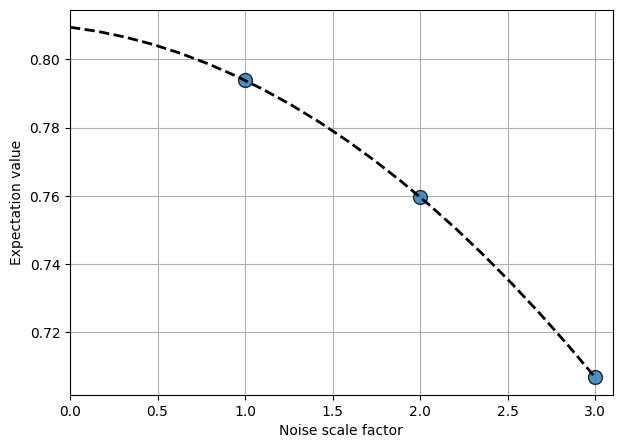

In [63]:
# Initialize a Richardson extrapolation object
richardson_factory = zne.RichardsonFactory(scale_factors)

# Load the previously measured data
for s, val in zip(scale_factors, noise_scaled_vals):
    richardson_factory.push({"scale_factor": s}, val)

print("The Richardson zero-noise extrapolation is:", richardson_factory.reduce())
_ = richardson_factory.plot_fit()

The linear zero-noise extrapolation is 0.8405166666666669


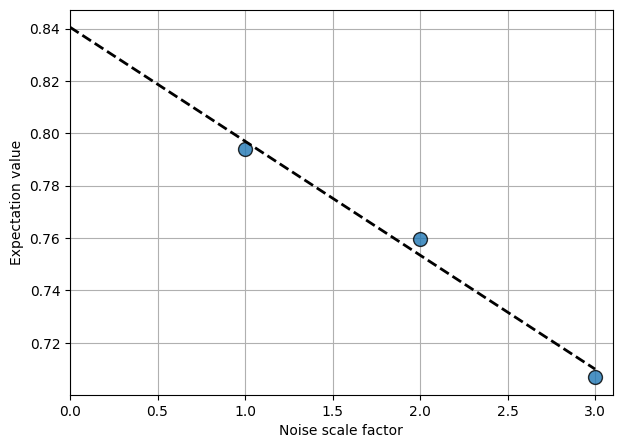

In [64]:
# Initialize a linear extrapolation object
linear_factory = zne.inference.LinearFactory(scale_factors) # TODO... see docs: https://mitiq.readthedocs.io/en/stable/apidoc.html#mitiq.zne.inference.LinearFactory

# Load the previously measured data
for s, val in zip(scale_factors, noise_scaled_vals):
    linear_factory.push({"scale_factor": s}, val)

print("The linear zero-noise extrapolation is", linear_factory.reduce())
_ = linear_factory.plot_fit()